# **Vision Sandbox**

Overarching notebook for exploring different facets of 3D vision topics in math and computer science

*Set up and imports*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Module 1: Image Stitching
In this module, I aim to employ homography and feature matching to stitch images together

In [3]:
room1 = cv2.imread(rf"Data\room1.jpeg")
room2 = cv2.imread(rf"Data\room2.jpeg")

room1 = cv2.resize(room1, (806,605))
room2 = cv2.resize(room2, (806,605))

(np.float64(-0.5), np.float64(805.5), np.float64(604.5), np.float64(-0.5))

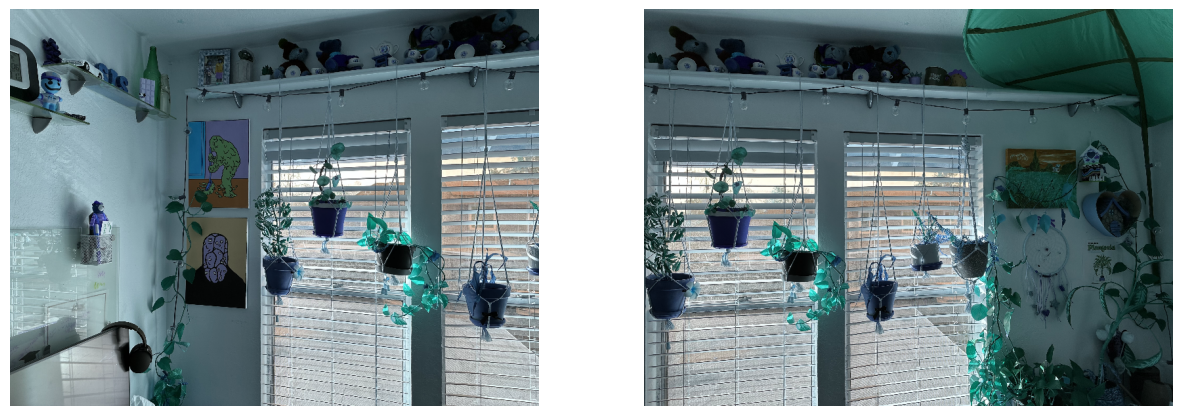

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(room1)
ax[1].imshow(room2)

ax[0].axis('off')
ax[1].axis('off')

Now that the images have been read, we need to extract features from both! 

To do so, we'll use ORB, a feature extractor that is rotation invariant. This means regardless of orientation, ORB will still be able to match the key points between the images!

In [5]:
# Display information on how to use ORB
orb = cv2.ORB_create()
help(orb)


Help on ORB in module cv2 object:

class ORB(Feature2D)
 |  Method resolution order:
 |      ORB
 |      Feature2D
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  getDefaultName(...)
 |      getDefaultName() -> retval
 |      .
 |  
 |  getEdgeThreshold(...)
 |      getEdgeThreshold() -> retval
 |      .
 |  
 |  getFastThreshold(...)
 |      getFastThreshold() -> retval
 |      .
 |  
 |  getFirstLevel(...)
 |      getFirstLevel() -> retval
 |      .
 |  
 |  getMaxFeatures(...)
 |      getMaxFeatures() -> retval
 |      .
 |  
 |  getNLevels(...)
 |      getNLevels() -> retval
 |      .
 |  
 |  getPatchSize(...)
 |      getPatchSize() -> retval
 |      .
 |  
 |  getScaleFactor(...)
 |      getScaleFactor() -> retval
 |      .
 |  
 |  getScoreType(...)
 |      getScoreType() -> retval
 |      .
 |  
 |  getWTA_K(...)
 |      getWTA_K() -> retval
 |      .
 |  
 |  setEdgeThreshold(...)
 |      setEdgeThreshold(ed

In [6]:
help(orb.detectAndCompute)

Help on built-in function detectAndCompute:

detectAndCompute(...) method of cv2.ORB instance
    detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]]) -> keypoints, descriptors
    .   Detects keypoints and computes the descriptors



(np.float64(-0.5), np.float64(805.5), np.float64(604.5), np.float64(-0.5))

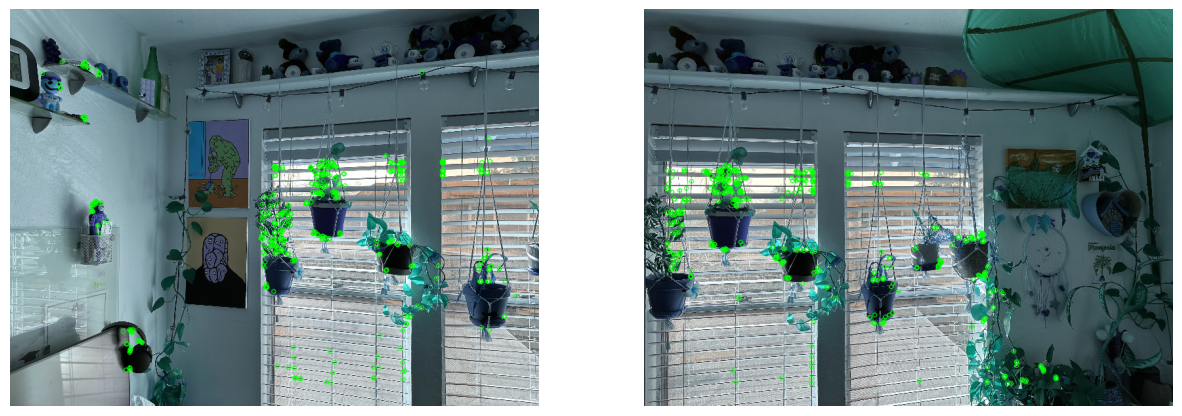

In [7]:
keyPts1, desc1 = orb.detectAndCompute(room1, None)
keyPts2, desc2 = orb.detectAndCompute(room2, None)

room1_feats = cv2.drawKeypoints(room1, keyPts1, None, color=(0,255,0))
room2_feats = cv2.drawKeypoints(room2, keyPts2, None, color=(0,255,0))

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(room1_feats)
ax[1].imshow(room2_feats)

ax[0].axis('off')
ax[1].axis('off')

Each of the results here has many options for key points, some of which will be good matches. At minimum we want to see 4 matches. This is because the homography matrix has 8 degrees of freedom and each correspondence solves for 2 constraints. ($8 DoFs / 2 values = 4 matches$)
\
\
\
That means our next step is simply finding the matches! Which we'll do using Brute-Force Matcher :)

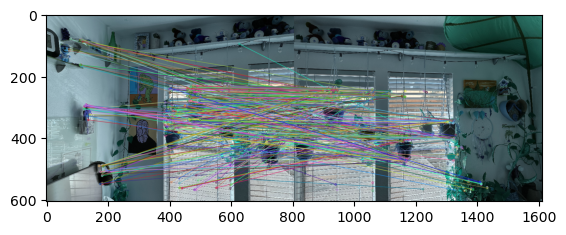

In [8]:
''' 
=>  In this situation we'll opt to use hamming distance instead of the typical L2 
    distance as the descriptors we compare are stored using binary strings.
'''
matcher = cv2.BFMatcher(cv2.NORM_HAMMING) 

matches = matcher.match(desc1, desc2)
rendered_matches = cv2.drawMatches(room1, keyPts1, room2, keyPts2, matches, None)
plt.imshow(rendered_matches)

After the matching, it appears like there's some matching that shouldn't be taking place. Of course, it's entirely possible that the features too similar to discern by BFMatcher but hopefully we can minimize the damage caused by that.
\
\
\
From researching further about BFMatcher, the results are not returned in a sorted order. To amend this problem, we can take the shortest distances in the matching as those will give us the best points of reference to stitch from.

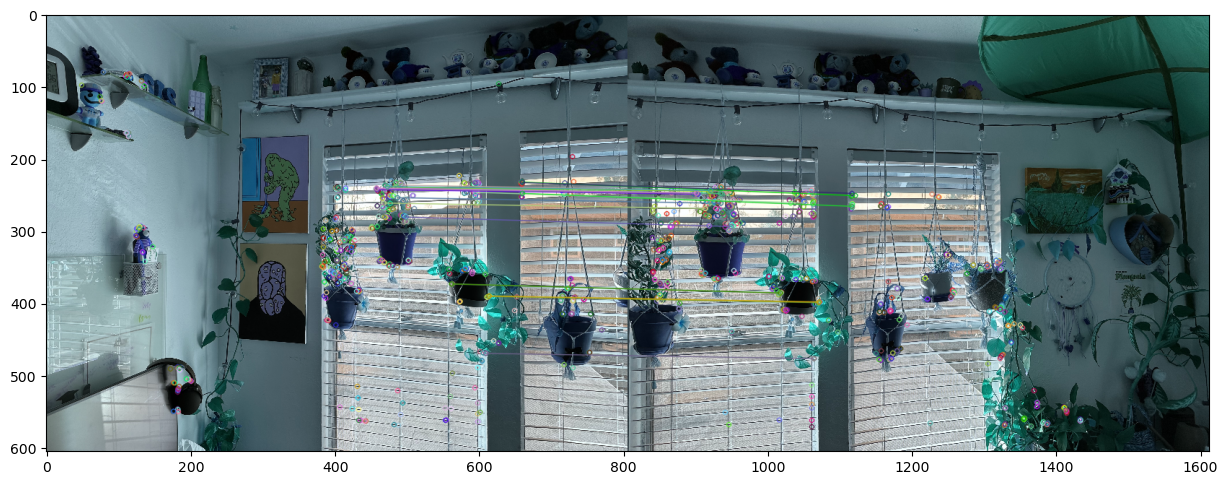

In [9]:
matches = sorted(matches, key=lambda x: x.distance)
n = 20

# With the matches sorted by distance, time to re-draw the top n results
top_n_rendered_matches = cv2.drawMatches(room1, keyPts1, room2, keyPts2, matches[:n], None)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(top_n_rendered_matches)

There seem to be a lot more than 20 good matches but if the stitching goes poorly, I can change the threshold to n matches.

The next step seems to be, find the n matches in their respective images

In [10]:
print(f'dist to match: {matches[0].distance} \nimgIdx: {matches[0].imgIdx} \nqueryIdx: {matches[0].queryIdx} \ntrainIdx: {matches[0].trainIdx}')

dist to match: 16.0 
imgIdx: 0 
queryIdx: 276 
trainIdx: 291


(np.float64(-0.5), np.float64(805.5), np.float64(604.5), np.float64(-0.5))

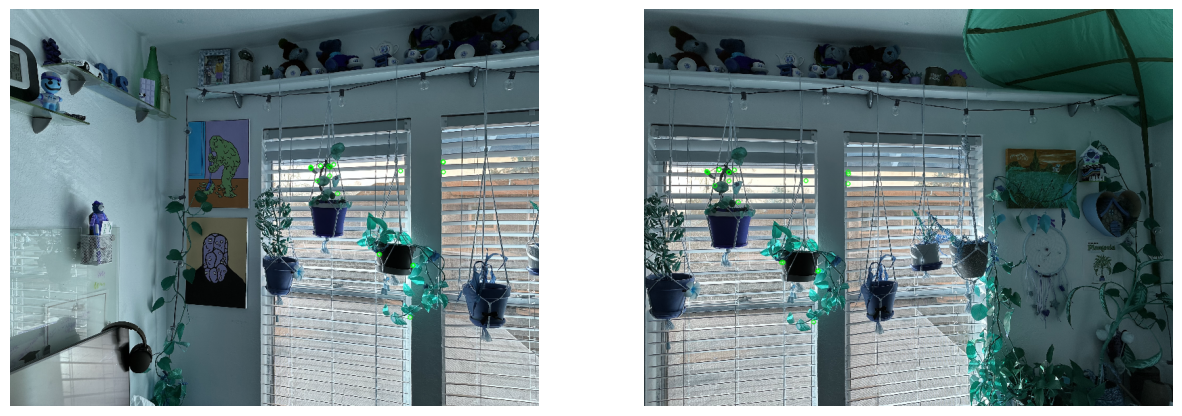

In [43]:
top_n_kps_1 = []
top_n_kps_2 = []
for i in range(n):
    top_n_kps_1.append(keyPts1[matches[i].queryIdx])
    top_n_kps_2.append(keyPts2[matches[i].trainIdx])

best_room1 = cv2.drawKeypoints(room1, tuple(top_n_kps_1), None, color=(0,255,0))
best_room2 = cv2.drawKeypoints(room2, tuple(top_n_kps_2), None, color=(0,255,0))


fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(best_room1)
ax[1].imshow(best_room2)

ax[0].axis('off')
ax[1].axis('off')

In [39]:
top_n_kps_1[0].pt
top_n_kps_2[0].pt

(264.384033203125, 399.16802978515625)

Now, we need to compute the homography matrix. The first step in this task is to represent the problem as a linear equation problem since all we're trying to learn is a linear transformation from one from of reference to another.
\
\
\
The basic idea is that for each point **X**, want to map it to some point **Y** using the equations:
- $x_{d}^{i}(h_{31}x_{s}^{i} + h_{32}y_{s}^{i} + h_{33}) = h_{11}x_{s}^{i} + h_{12}y_{s}^{i} + h_{13}$
- $y_{d}^{i}(h_{31}x_{s}^{i} + h_{32}y_{s}^{i} + h_{33}) = h_{21}x_{s}^{i} + h_{22}y_{s}^{i} + h_{23}$

Where d = destination, s = source, and i = idx of feature match to solve for a 3x3 homograph matrix **H**

In [37]:
A_rows = []
for pts, ptd in zip(top_n_kps_1, top_n_kps_2):
    xs, ys = pts.pt
    xd, yd = ptd.pt
    A_rows.append([xs, ys, 1, 0, 0, 0, -xd * xs, -xd * ys, -xd])
    A_rows.append([0, 0, 0, xs, ys, 1, -yd * xs, -yd * ys, -yd])


A = np.array(A_rows)
print(A.shape)
print(A[:4])

(40, 9)
[[ 6.13440063e+02  3.90528046e+02  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.62183758e+05 -1.03249380e+05
  -2.64384033e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.13440063e+02
   3.90528046e+02  1.00000000e+00 -2.44865662e+05 -1.55886311e+05
  -3.99168030e+02]
 [ 6.13785706e+02  3.89836853e+02  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.62911516e+05 -1.03470824e+05
  -2.65420837e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.13785706e+02
   3.89836853e+02  1.00000000e+00 -2.44367274e+05 -1.55206236e+05
  -3.98131256e+02]]


We've created a linear system where $Ah = b$ s.t. h is the resulting homography and b = 0. We can't solve for it directly as we'd reach an immediate solution where h = **0** vector so instead we must place an arbitrary restriction on h where $||h||^2 = 1$. Then we're free to solve for h!
\
\
\
We'll use constrained least squares which we can denote as:

$$\min_{h} ||Ah||^2$$

So then it follows that:

$$Loss\ function\ L(h,\lambda)=h^{T}A^{T}Ah - \lambda(h^{T}h - 1)$$

Who's minimum can be solved by taking the derivative w.r.t. h:
$$2A^TAh - 2\lambda h = 0$$
$$A^TAh = \lambda h$$
\
\
Therefore, we take the SVD of $A^TA$ and extract its smallest eigenvector which gives us **h**!

In [87]:
square = A.T@A
S, Vt = np.linalg.eigh(square)
print(S)

[2.02756702e-04 1.43085186e-02 8.51409188e+02 1.14896735e+04
 5.43496316e+04 5.85952851e+05 7.46189387e+06 1.29411033e+10
 1.12239226e+12]


In [88]:
x_source, y_source = top_n_kps_1[0].pt
x_dest, y_dest = top_n_kps_2[0].pt

source = np.array((x_source, y_source, 1))
dest = np.array((x_dest, y_dest, 1))
print(source)
print(dest)

[613.44006348 390.52804565   1.        ]
[264.3840332  399.16802979   1.        ]


In [89]:
h = Vt[:, 0]
H = np.reshape(h, shape=(3, 3))
print(H)

[[ 2.54602340e-03 -4.50563764e-05 -9.69012640e-01]
 [ 4.90389040e-04  2.09587041e-03 -2.46985365e-01]
 [ 1.49708104e-06 -1.94851944e-08  1.27083633e-03]]


In [90]:
left = square@h
right = min(S)*h
print(left)
print(right)

[ 1.30403350e-06 -1.12218913e-06 -1.95594875e-04  4.81782081e-08
  3.87918817e-07 -5.00780753e-05 -1.77561305e-05 -8.12602229e-06
  2.29286343e-07]
[ 5.16223309e-07 -9.13548229e-09 -1.96473807e-04  9.94296645e-08
  4.24951772e-07 -5.00779381e-05  3.03543214e-10 -3.95075375e-12
  2.57670582e-07]


In [91]:
guess = H@source
print(guess/guess[-1])
print(dest)

[263.67130352 399.86091561   1.        ]
[264.3840332  399.16802979   1.        ]


In [81]:
B = np.array(
    [[1,2,3],
     [4,5,6]]
)

sb = B.T@B
s, vt = np.linalg.eigh(sb)
l = sb@vt[:, -1]
r = s[-1]*vt[:, -1]
print(l)
print(r)

[-38.7526545  -51.19565893 -63.63866337]
[-38.7526545  -51.19565893 -63.63866337]
